In [5]:
import pandas as pd
import re

# -----------------------------
# 1. List of revised IPEDS files (now including 2020)
# -----------------------------
file_paths = [
    "c2019_a_rv.csv",
    "c2020_a_rv.csv",   # <- added 2020
    "c2021_a_rv.csv",
    "c2022_a_rv.csv",
    "C2023_a_RV.csv",   # keep exact name/case from your folder
]

# -----------------------------
# 2. Helper function to clean one file
# -----------------------------
def clean_ipeds_completions(path: str) -> pd.DataFrame:
    # Infer year from filename (first 4 digits)
    m = re.search(r"(20\d{2})", path)
    year = int(m.group(1)) if m else None

    # Read as string first
    df = pd.read_csv(
        path,
        dtype=str,
        low_memory=False,
        na_values=[".", "NA", "N/A", "NULL", ""]
    )

    # Standardize column names
    df.columns = (
        df.columns.str.lower()
                  .str.strip()
                  .str.replace(r"[^\w]+", "_", regex=True)
                  .str.replace(r"_+", "_", regex=True)
                  .str.strip("_")
    )

    # Columns to KEEP as text even if they look numeric
    text_like_cols = {
        "unitid", "opeid", "cipcode", "majornum", "awlevel", "line"
    }

    # Convert other columns to numeric when appropriate
    for col in df.columns:
        if col in text_like_cols:
            continue

        sample = df[col].dropna().astype(str)
        if sample.empty:
            continue

        cleaned = sample.str.replace(r"[0-9\.\-]", "", regex=True)
        if (cleaned == "").all():
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Add year column
    df["year"] = year

    return df

# -----------------------------
# 3. Clean all files and stack
# -----------------------------
frames = []
for path in file_paths:
    print(f"Loading and cleaning: {path}")
    frames.append(clean_ipeds_completions(path))

completions_all = pd.concat(frames, ignore_index=True)

# -----------------------------
# 4. Quick sanity checks
# -----------------------------
print("Rows:", len(completions_all))
print("Columns:", len(completions_all.columns))
print("Years in data:", sorted(completions_all["year"].dropna().unique()))
print("\nSample columns:", completions_all.columns[:20].tolist())
print("\nHead:")
print(completions_all.head())


Loading and cleaning: c2019_a_rv.csv
Loading and cleaning: c2020_a_rv.csv
Loading and cleaning: c2021_a_rv.csv
Loading and cleaning: c2022_a_rv.csv
Loading and cleaning: C2023_a_RV.csv
Rows: 1481685
Columns: 65
Years in data: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

Sample columns: ['unitid', 'cipcode', 'majornum', 'awlevel', 'xctotalt', 'ctotalt', 'xctotalm', 'ctotalm', 'xctotalw', 'ctotalw', 'xcaiant', 'caiant', 'xcaianm', 'caianm', 'xcaianw', 'caianw', 'xcasiat', 'casiat', 'xcasiam', 'casiam']

Head:
   unitid  cipcode majornum awlevel xctotalt  ctotalt xctotalm  ctotalm  \
0  100654  01.0999        1      05        R        6        Z        0   
1  100654  01.1001        1      05        R        7        R        2   
2  100654  01.1001        1      07        R        8        R        2   
3  100654  01.1001        1      17        R        2        Z        0   
4  100654  01.9999        1      05        R        2        R        1   


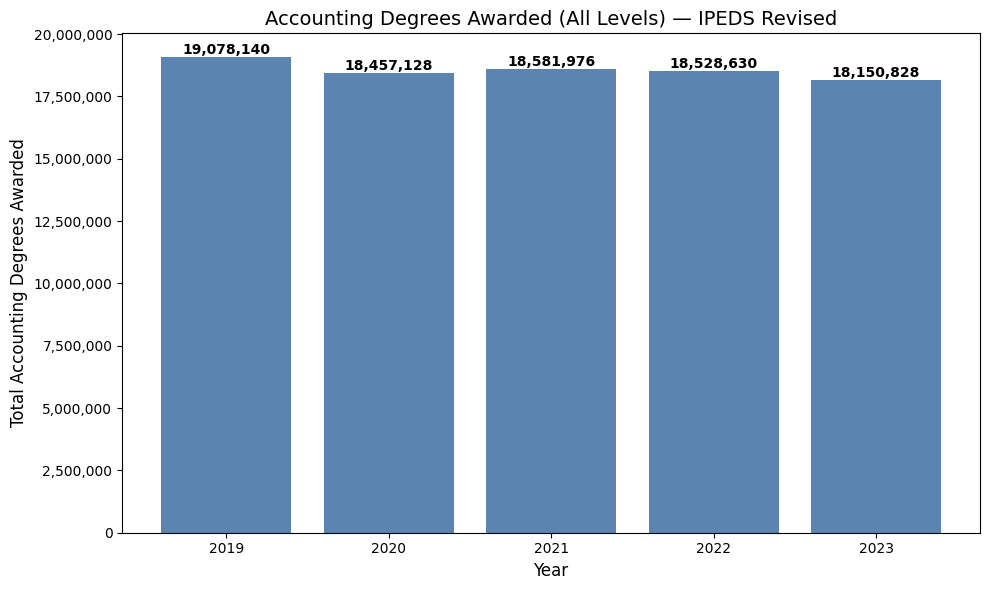

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------------------------------
# 1. Make sure awards_total exists
# ---------------------------------
numeric_cols = completions_all.select_dtypes(include="number").columns
completions_all["awards_total"] = completions_all[numeric_cols].sum(axis=1)

# ---------------------------------
# 2. Filter Accounting degrees
# ---------------------------------
acct = completions_all[completions_all["cipcode"] == "52.0301"]

acct_yearly = (
    acct.groupby("year")["awards_total"]
        .sum()
        .reset_index()
        .sort_values("year")
)

# convert to int
acct_yearly["year"] = acct_yearly["year"].astype(int)

# ---------------------------------
# 3. Plot
# ---------------------------------
plt.figure(figsize=(10,6))
bars = plt.bar(acct_yearly["year"], acct_yearly["awards_total"], color="#5b84b1ff")

plt.title("Accounting Degrees Awarded (All Levels) — IPEDS Revised", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Accounting Degrees Awarded", fontsize=12)
plt.xticks(acct_yearly["year"])

# ---------------------------------
# Format Y axis with commas (NO scientific notation)
# ---------------------------------
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x):,}")
)

# ---------------------------------
# 4. Add labels ON TOP of bars
# ---------------------------------
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


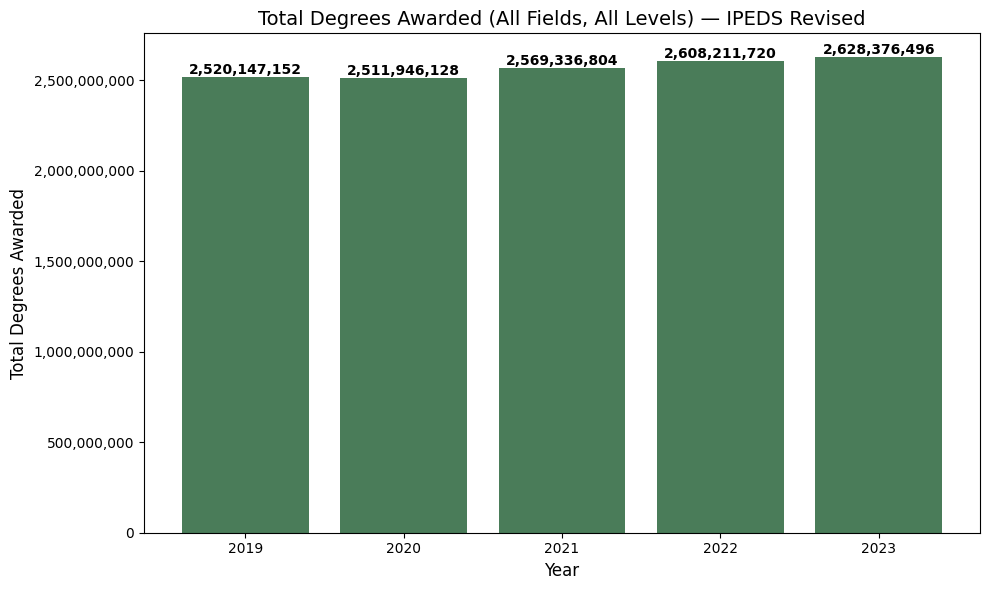

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------------------------------------------------------
# 1. Make sure awards_total exists
# ---------------------------------------------------------
numeric_cols = completions_all.select_dtypes(include="number").columns
completions_all["awards_total"] = completions_all[numeric_cols].sum(axis=1)

# ---------------------------------------------------------
# 2. Aggregate all degrees by year
# ---------------------------------------------------------
all_yearly = (
    completions_all.groupby("year")["awards_total"]
                   .sum()
                   .reset_index()
                   .sort_values("year")
)

all_yearly["year"] = all_yearly["year"].astype(int)

# ---------------------------------------------------------
# 3. Plot
# ---------------------------------------------------------
plt.figure(figsize=(10,6))
bars = plt.bar(all_yearly["year"], all_yearly["awards_total"], color="#4a7c59")

plt.title("Total Degrees Awarded (All Fields, All Levels) — IPEDS Revised", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Degrees Awarded", fontsize=12)
plt.xticks(all_yearly["year"])

# Format Y axis with commas
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x):,}")
)

# ---------------------------------------------------------
# 4. Add totals on top of bars
# ---------------------------------------------------------
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


All majors:
    year  total_degrees  bachelors_degrees  masters_degrees
0  2019      630036788        226129695.0       92447038.0
1  2020      627986532        227012936.0       94034280.0
2  2021      642334201        227413079.0       95774495.0
3  2022      652052930        228402646.0       97088524.0
4  2023      657094124                0.0              0.0

Accounting only:
    year  total_degrees  bachelors_degrees  masters_degrees
0  2019        6359380          3204959.0        1161179.0
1  2020        6152376          3163304.0        1136892.0
2  2021        6193992          3167178.0        1138114.0
3  2022        6176210          3150702.0        1130288.0
4  2023        6050276                0.0              0.0


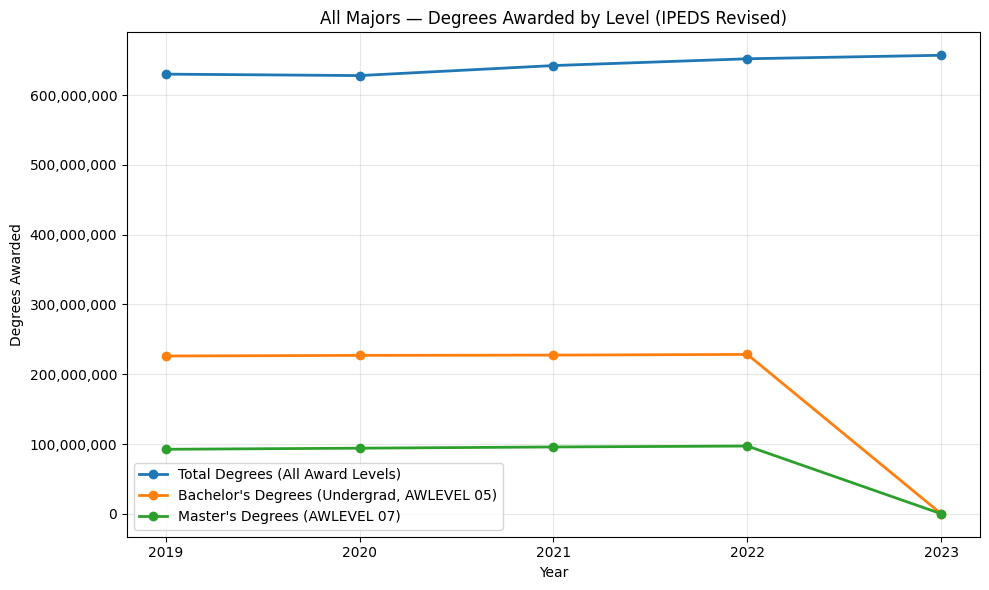

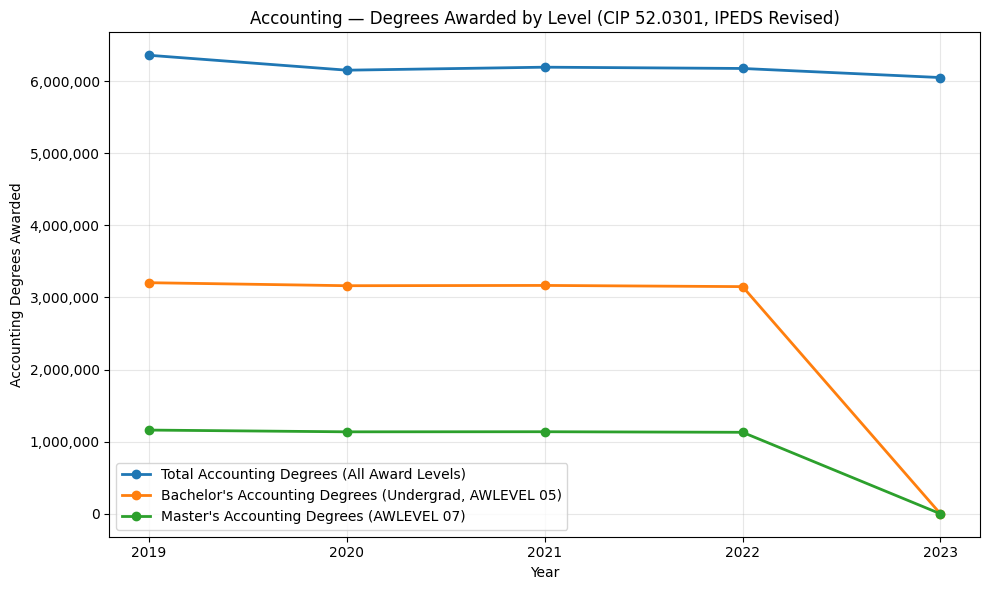

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------------------------------------------------------
# 1. Make sure awards_total exists (sum of all numeric award columns)
# ---------------------------------------------------------
numeric_cols = completions_all.select_dtypes(include="number").columns.tolist()
# Avoid double-counting if awards_total already exists
if "awards_total" in numeric_cols:
    numeric_cols.remove("awards_total")

completions_all["awards_total"] = completions_all[numeric_cols].sum(axis=1)

# Ensure year is numeric
completions_all["year"] = completions_all["year"].astype(int)

# ---------------------------------------------------------
# 2. Helper: build totals by year for a given subset (all majors or accounting)
# ---------------------------------------------------------
def build_yearly_degree_lines(df_subset: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a dataframe with columns:
    year, total_degrees, bachelors_degrees, masters_degrees
    """
    # Total degrees (all award levels)
    total = (
        df_subset.groupby("year")["awards_total"]
                 .sum()
                 .rename("total_degrees")
    )

    # Undergrad (Bachelor's: awlevel == '05')
    ba = (
        df_subset[df_subset["awlevel"] == "05"]
        .groupby("year")["awards_total"]
        .sum()
        .rename("bachelors_degrees")
    )

    # Masters (awlevel == '07')
    ma = (
        df_subset[df_subset["awlevel"] == "07"]
        .groupby("year")["awards_total"]
        .sum()
        .rename("masters_degrees")
    )

    out = pd.concat([total, ba, ma], axis=1).fillna(0).reset_index()
    out = out.sort_values("year")
    return out

# ---------------------------------------------------------
# 3. Build lines for: (a) all majors, (b) accounting only
# ---------------------------------------------------------
all_majors_yearly = build_yearly_degree_lines(completions_all)

acct_only = completions_all[completions_all["cipcode"] == "52.0301"]
acct_yearly = build_yearly_degree_lines(acct_only)

print("All majors:\n", all_majors_yearly)
print("\nAccounting only:\n", acct_yearly)

# Formatter for y-axis (comma-separated integers)
formatter = FuncFormatter(lambda y, _: f"{int(y):,}")

# ---------------------------------------------------------
# 4. Graph 1: All majors
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

plt.plot(
    all_majors_yearly["year"],
    all_majors_yearly["total_degrees"],
    marker="o",
    linewidth=2,
    label="Total Degrees (All Award Levels)"
)

plt.plot(
    all_majors_yearly["year"],
    all_majors_yearly["bachelors_degrees"],
    marker="o",
    linewidth=2,
    label="Bachelor's Degrees (Undergrad, AWLEVEL 05)"
)

plt.plot(
    all_majors_yearly["year"],
    all_majors_yearly["masters_degrees"],
    marker="o",
    linewidth=2,
    label="Master's Degrees (AWLEVEL 07)"
)

plt.title("All Majors — Degrees Awarded by Level (IPEDS Revised)")
plt.xlabel("Year")
plt.ylabel("Degrees Awarded")
plt.xticks(all_majors_yearly["year"])
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. Graph 2: Accounting only
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

plt.plot(
    acct_yearly["year"],
    acct_yearly["total_degrees"],
    marker="o",
    linewidth=2,
    label="Total Accounting Degrees (All Award Levels)"
)

plt.plot(
    acct_yearly["year"],
    acct_yearly["bachelors_degrees"],
    marker="o",
    linewidth=2,
    label="Bachelor's Accounting Degrees (Undergrad, AWLEVEL 05)"
)

plt.plot(
    acct_yearly["year"],
    acct_yearly["masters_degrees"],
    marker="o",
    linewidth=2,
    label="Master's Accounting Degrees (AWLEVEL 07)"
)

plt.title("Accounting — Degrees Awarded by Level (CIP 52.0301, IPEDS Revised)")
plt.xlabel("Year")
plt.ylabel("Accounting Degrees Awarded")
plt.xticks(acct_yearly["year"])
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
